# TED-Talks topic models

![](http://greatperformersacademy.com/images/images/Articles_images/10-best-ted-talks-ever.jpg)

In this notebook we will study text processing using TED transcripts, passing through feature extraction to topic modeling in order to (1) have a first meet with text processing techniques and (2) analyze briefly some TED-Talks patterns.

In the amazing TED-Talks dataset, we have two files, one (ted_main.csv) with meta information about the talks, as # of comment, rating, related TEDs and so on; the other file has the transcripts which we'll care about in this tutorial. Even so, we'll use the ted_main.csv file to evaluate our topic modeling implementation, because it has a columns of talks' tags, useful as our "ground truth topics".

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

### 0.1. Transcripts loading

In [2]:
ted_main_df = pd.read_csv('../input/ted_main.csv', encoding='utf-8')
transcripts_df = pd.read_csv('../input/transcripts.csv', encoding='utf-8')

In [3]:
ted_main_df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [4]:
transcripts_df.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [5]:
transcripts_df['transcript'][0]

'Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you

## 1. Text feature extraction with TFIDF

First,  consider the term-frequency (TF) matrix above, that can be extracted from a list of documents and the universe of terms in such documents.

|        | Document 1 | Document 2 | ... | Document N |
|--------|------------|------------|-----|------------|
| Term 1 | 3          | 0          | ... | 1          |
| Term 2 | 0          | 1          | ... | 2          |
| Term 3 | 2          | 2          | ... | 1          |
| ...    | ...        | ...        | ... | ...        |
| Term N | 1          | 0          | ... | 0          |


This is a huge matrix with all elements' frequency in all documents. Now consider de idf (inverse document frequency) as an operation to transform this frequency into word importance, calculated by:

$$ tfidf_{i,j} = tf_{i,j}  \times log(\frac{N}{df_{i}}) $$

Where $i$ refers to term index and $j$ document index. $N$ is the total number of documents and $df_{i}$ is the number of documents containing $i$.



In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), # considering only 1-grams
                        min_df = 0.05,     # cut words present in less than 5% of documents
                        max_df = 0.3)      # cut words present in more than 30% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(transcripts_df['transcript'])
print("done in %0.3fs." % (time() - t0))

done in 5.669s.


In [7]:
type(tfidf)

scipy.sparse.csr.csr_matrix

Keeping that in mind, we'll want to see the 'most important' words in our matrix...

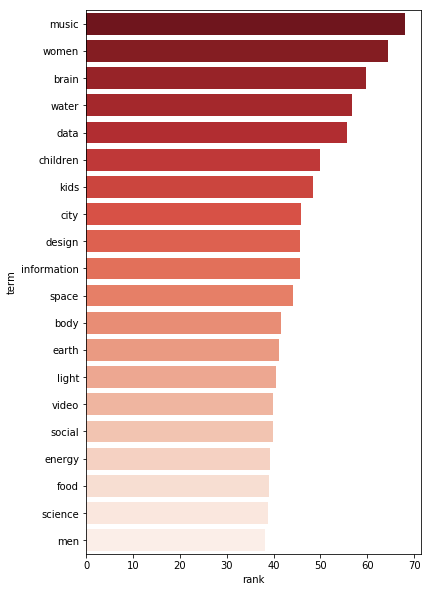

In [8]:
# Let's make a function to call the top ranked words in a vectorizer
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);

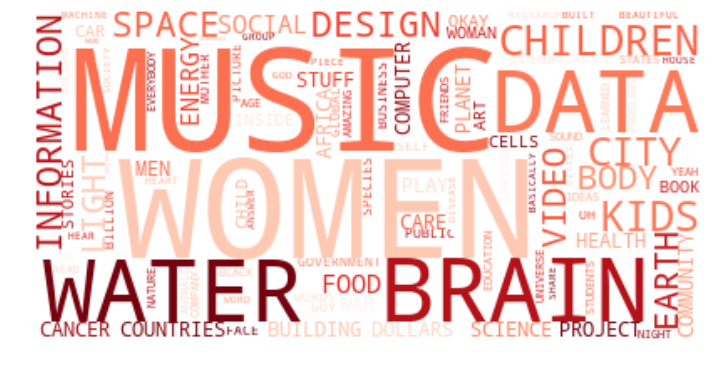

In [9]:
# Let's visualize a word cloud with the frequencies obtained by idf transformation
dic = {ranked.loc[i,'term'].upper(): ranked.loc[i,'rank'] for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      colormap='Reds').generate_from_frequencies(dic)
fig = plt.figure(1,figsize=(12,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

## 2. Topic modeling

Not recently decomposition techniques have been used to extract topics from text data. A topic is a mixture of words and a document should be pertinent to a topic if these words are present in there. Look at the diagram to understand better.

![alt text](https://image.ibb.co/kH9t87/d.png)

Here we will extract topics from NMF and LDA to check for better results. First, let's try LDA.

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)

topics = lda.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

C:\Users\Yang\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


{0: ['women', 'brain', 'music', 'data', 'children'],
 1: ['push', 'middle', 'beings', 'fish', 'carbon'],
 2: ['happiness', 'welcome', 'ca', 'education', 'chose'],
 3: ['music', 'ends', 'starts', 'species', 'brain'],
 4: ['cities', 'wait', 'morning', 'community', 'arm'],
 5: ['ca', 'cancer', 'computer', 'aids', 'head'],
 6: ['earth', 'ocean', 'planet', 'water', 'universe'],
 7: ['blue', 'sounds', 'planet', 'music', 'sound'],
 8: ['film', 'mother', 'woman', 'oh', 'everybody'],
 9: ['cells', 'cancer', 'cell', 'brain', 'blood']}

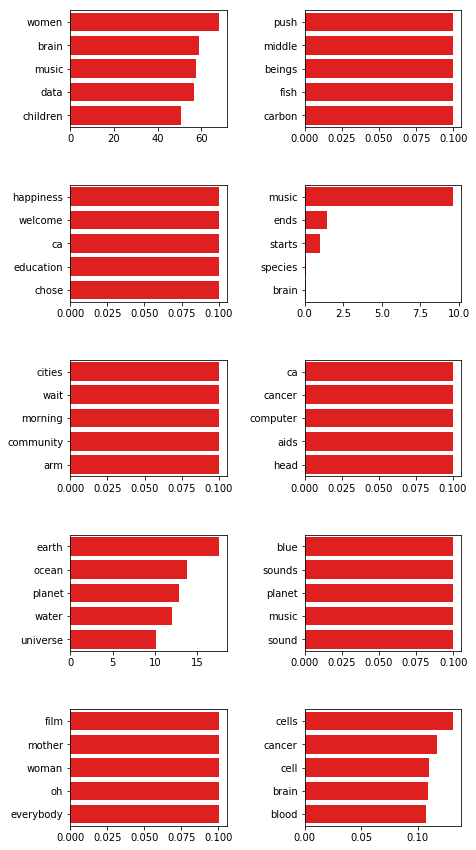

In [11]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

Not so bad, but there are topics that has words fairly inappropriate togheter, and also repeated ones among topics. We could say that these topics are uncohesive for humans. That is common difficult when applying topic modeling to real problems. 

Another problem is the optimal number of topics. There are several ways to validate it, as with perplexity or log-likelyhood. However, let's keep with 10 topics! :)

In [12]:
from sklearn.decomposition import NMF

n_topics = 10
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

{0: ['god', 'book', 'stories', 'oh', 'art'],
 1: ['women', 'men', 'girls', 'woman', 'sex'],
 2: ['music', 'play', 'sound', 'song', 'ends'],
 3: ['brain', 'brains', 'cells', 'body', 'activity'],
 4: ['water', 'earth', 'planet', 'ocean', 'species'],
 5: ['countries', 'africa', 'government', 'global', 'dollars'],
 6: ['cancer', 'cells', 'patients', 'disease', 'cell'],
 7: ['data', 'information', 'computer', 'machine', 'internet'],
 8: ['city', 'design', 'cities', 'building', 'buildings'],
 9: ['kids', 'children', 'education', 'students', 'teachers']}

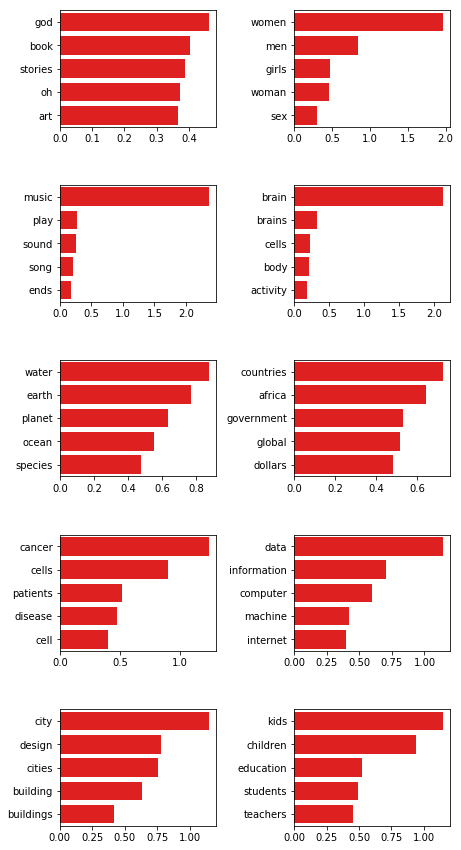

In [13]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

Hmm. Now you see that with NMF things got better. So, we'll use it testing for a document and see what topics are extracted.

In [14]:
# Formulating a pipeline to insert a document and extract the topics pertinency
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

document_id = 4
t = pipe.transform([transcripts_df['transcript'].iloc[document_id]]) 
print('Topic distribution for document #{}: \n'.format(document_id),t)
print('Relevant topics for document #{}: \n'.format(document_id),np.where(t>0.01)[1])
print('\nTranscript:\n',transcripts_df['transcript'].iloc[document_id][:500],'...')

talk = ted_main_df[ted_main_df['url']==transcripts_df['url'].iloc[document_id]]
print('\nTrue tags from ted_main.csv: \n',talk['tags'])

Topic distribution for document #4: 
 [[0.         0.         0.         0.         0.         0.12571269
  0.         0.06484601 0.         0.04395516]]
Relevant topics for document #4: 
 [5 7 9]

Transcript:
 About 10 years ago, I took on the task to teach global development to Swedish undergraduate students. That was after having spent about 20 years together with African institutions studying hunger in Africa, so I was sort of expected to know a little about the world. And I started in our medical university, Karolinska Institute, an undergraduate course called Global Health. But when you get that opportunity, you get a little nervous. I thought, these students coming to us actually have the highes ...

True tags from ted_main.csv: 
 4    ['Africa', 'Asia', 'Google', 'demo', 'economic...
Name: tags, dtype: object


Seems nice! The transcript #4 really talk about topic #5.

Now we would do a exploratory analysis about our topics and extract descriptitve statistics and visualizations for the transcripts.

In [15]:
t = pipe.transform(transcripts_df['transcript']) 
t = pd.DataFrame(t, columns=[str(t_words[i]) for i in range(0,10)])
t.head()

,"['god', 'book', 'stories', 'oh', 'art']","['women', 'men', 'girls', 'woman', 'sex']","['music', 'play', 'sound', 'song', 'ends']","['brain', 'brains', 'cells', 'body', 'activity']","['water', 'earth', 'planet', 'ocean', 'species']","['countries', 'africa', 'government', 'global', 'dollars']","['cancer', 'cells', 'patients', 'disease', 'cell']","['data', 'information', 'computer', 'machine', 'internet']","['city', 'design', 'cities', 'building', 'buildings']","['kids', 'children', 'education', 'students', 'teachers']"
0,0.051649,0.027345,0.032306,0.022761,0.016689,0.000000,0.000000,0.000000,0.000000,0.161270
1,0.032398,0.000000,0.000214,0.000000,0.035636,0.073223,0.000000,0.003849,0.039427,0.000000
2,0.069650,0.000000,0.037967,0.000000,0.000000,0.011949,0.000000,0.084859,0.008037,0.000000
3,0.009026,0.011402,0.000000,0.000000,0.021518,0.063003,0.001436,0.000000,0.153938,0.032074
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.125713,0.000000,0.064846,0.000000,0.043955


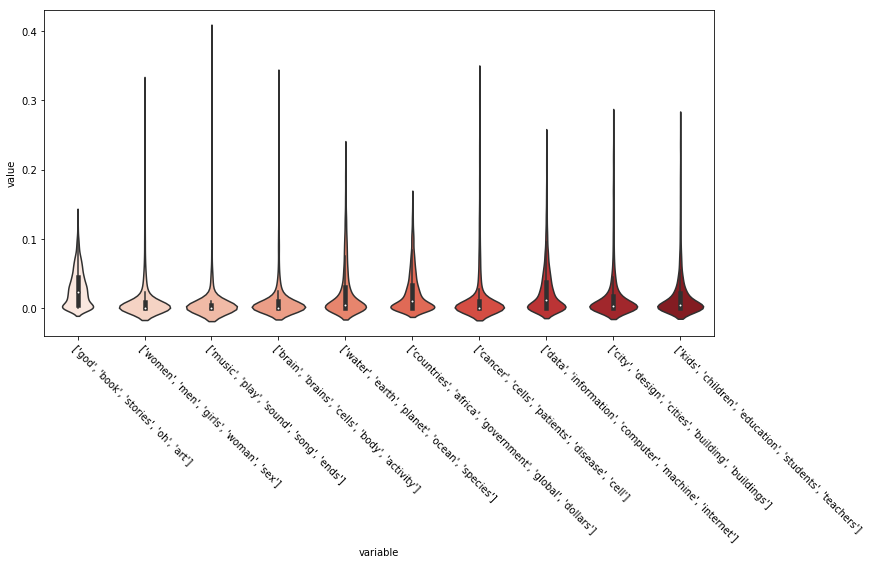

In [16]:
new_t = t.melt()

# fig = plt.figure(1,figsize=(12,6))
fig, ax = plt.subplots(figsize=(12,6), ncols=1, nrows=1)
sns.violinplot(x="variable", y="value", data=new_t, palette='Reds', ax=ax)
# plt.xticks(rotation=75)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 

plt.show()

A couple of things to conclude:

1. Topic #0 (['god', 'book', 'stories', 'oh', 'art']) is very general itself in terms of words' meaning and perhaps this explain this even result when its distribution is compared to the others. 
2. Topic #2 represent talks about music and we can see it has the strongest outlier.
3. Topics **#4 (about earth), #5 (about government), #7 (about data&information) and #9 (about education)** have high quartiles, meaning that they are the most frequent topics that TED Talks carry on.

Hope that this **ideas that really matter and worth spreading** were well modeled and could help NLP beginners!